In [1]:
import torch
import torch.nn as nn
import tntorch as tn
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizerFast

torch.manual_seed(0)
np.random.seed(0)

%config InlineBackend.figure_format = "svg"

from TTLinear import TTLinear

In [2]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tok = BertTokenizerFast.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
for layer in model.bert.encoder.layer:
    print(layer)
    break

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [19]:
idx = 0

weight_in = model.bert.encoder.layer[idx].intermediate.dense.weight.data.T
weight_out = model.bert.encoder.layer[idx].output.dense.weight.data.T

In [20]:
weight_in.shape, weight_out.shape

(torch.Size([768, 3072]), torch.Size([3072, 768]))

In [114]:
from torch.linalg import matrix_norm as frob_norm
import tntorch as tn
from tqdm import tqdm

In [125]:
in_dims = [4,6,8,4]
out_dims = [8,8,6,8]
ranks = [50,50,50]

In [126]:
tt_weight_in = tn.TTMatrix(weight_in, ranks, in_dims, out_dims)

In [127]:
frob_norm(tt_weight_in.torch() - weight_in) / frob_norm(weight_in)

tensor(0.9261)

In [128]:
sum(c.numel() for c in tt_weight_in.cores), weight_in.numel()

(155648, 2359296)

In [141]:
torch.manual_seed(1)

height = 768
width = 3072
n_trials = 100

errors = []

for seed in tqdm(range(n_trials)):
    h_perm = torch.randperm(height)
    inv_h_perm = torch.empty_like(h_perm)
    inv_h_perm[h_perm] = torch.arange(height)
    
    w_perm = torch.randperm(width)
    inv_w_perm = torch.empty_like(w_perm)
    inv_w_perm[w_perm] = torch.arange(width)
    
    shuffled = weight_in.clone()
    shuffled = shuffled[h_perm][:, w_perm]
    
    tt_weight_in = tn.TTMatrix(shuffled, ranks, in_dims, out_dims)
    
    #tt_weight_in = tn.TTMatrix(weight_in[h_perm][:, w_perm], ranks, in_dims, out_dims)
    
    recon = tt_weight_in.torch()
    recon = recon[inv_h_perm][:, inv_w_perm]
    
    errors.append(frob_norm(recon - weight_in) / frob_norm(weight_in)) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


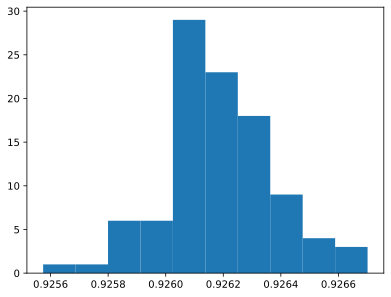

In [142]:
plt.hist(errors)
plt.show()

In [131]:
x = torch.randn(100, perm_len)

In [132]:
x.shape, weight_in.shape

(torch.Size([100, 768]), torch.Size([768, 3072]))

In [110]:
torch.allclose(x[:, perm] @ weight_in[perm], x @ weight_in, atol=1e-5)

True